# Tutorial: Strain in a heterostructured nanowire

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from stm.utils.plotutils import add_colorbar
matplotlib.rcParams.update({'font.size': 12})
figsize=8

In this tutorial we will investigate the strain in a HRTEM image of a heterostructured wurtzite InAs/InP nanowire using real space peak finding and structural template matching. The structure is viewed along the [$01\bar{1}0$] zone axis.

The Hyperspy package imports many common [image formats](http://hyperspy.org/hyperspy-doc/current/user_guide/io.html), including .dm3, .dm4 and .tif.

In [2]:
import hyperspy.api as hs
from stm.preprocess import normalize

The Bruker composite file reader can not be loaded because the lxml library is not installed. To enable it install the Python lxml package.


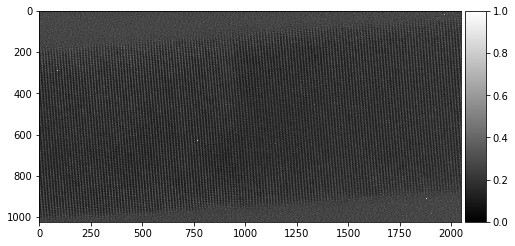

In [3]:
s = hs.load('data/images/InAs-InP_20nm_559000X_21.dm3')

#s = hs.load('examples/images/InAs-InP-765_559000X_7.dm3')

#image = s.data[1000:1300,650:1400].T
image = normalize(s.data[:,586:1610])

fig,ax=plt.subplots(figsize=(figsize,figsize/2))
im=ax.imshow(image.T)
add_colorbar(ax, im)

## Image preprocessing
Noise degrades the accuracy of the positions of the identified structures and hence the final strain measurements. Frequently used spatial filters for denoising HR(S)TEM images include Wiener filter, Gaussian filter and Bragg filter.

[Scikit-image](http://scikit-image.org/) provides a large selection filters including a Wiener filter and a Gaussian filter under the [restoration](http://scikit-image.org/docs/dev/api/skimage.restoration.html) and [filters](http://scikit-image.org/docs/dev/api/skimage.filters.html) modules respectively. Here we will use the Wiener filter from scikit-image and the Bragg filter provided through the `BraggFilter` object.

In [5]:
from stm.preprocess.filters import BraggFilter, butterworth_mask
from skimage.restoration import wiener

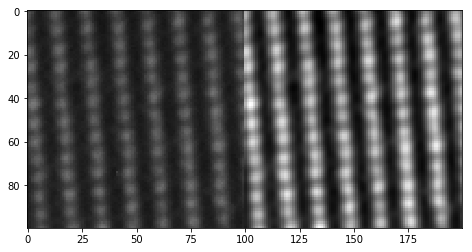

In [6]:
filtered_once = normalize(wiener(image, np.array([[0,0,0],[0,1,0],[0,0,0]]), 1))

fig, ax = plt.subplots(1,1,figsize=(figsize,figsize/2))
ax.imshow(np.hstack((image[600:700,600:700].T,filtered_once[600:700,600:700].T)));

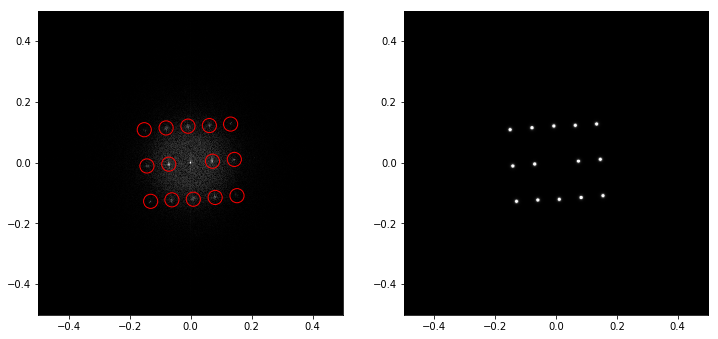

In [7]:
bragg = BraggFilter(filtered_once)

bragg.autoset_vectors(min_distance=100, threshold=.5, exclusion_radius=100)

fig,axes=plt.subplots(1,2,figsize=(3*figsize/2,3*figsize/4))
bragg.display_vectors(ax=axes[0], scale=0.01, s=200)
bragg.display_mask(ax=axes[1], mask=butterworth_mask(5, ratio=2, order=4));

In [8]:
filtered, mask = bragg.apply_filter(mask = butterworth_mask(8, ratio=2, order=4), return_mask=True)

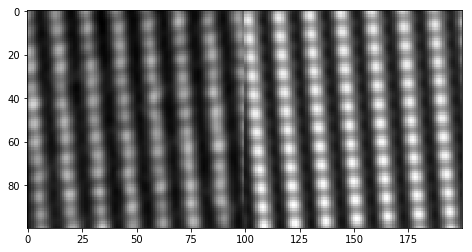

In [9]:
fig, ax = plt.subplots(1,1,figsize=(figsize,figsize/2))
ax.imshow(np.hstack((filtered_once[600:700,600:700].T, filtered[600:700,600:700].T)));

## Peak detection
Once we have a filtered image, the next step is to locate the structures in the image. In the simple case, each structure corresponds to a high-intensity peak. In cases where each structure does not correspond a single peak, it may be possible to use template matching (see tutorial).

The function `find_local_peaks` may be used to automatically identify the pixel positions of local intensity maxima in the image. A simple graphical user interface for manually adding missing or removing erronous peaks is provided through the PointsEditor object.

In [10]:
from stm.feature.peaks import find_local_peaks

In [11]:
points = find_local_peaks(filtered, min_distance=7, threshold=.6, exclude_border=10)

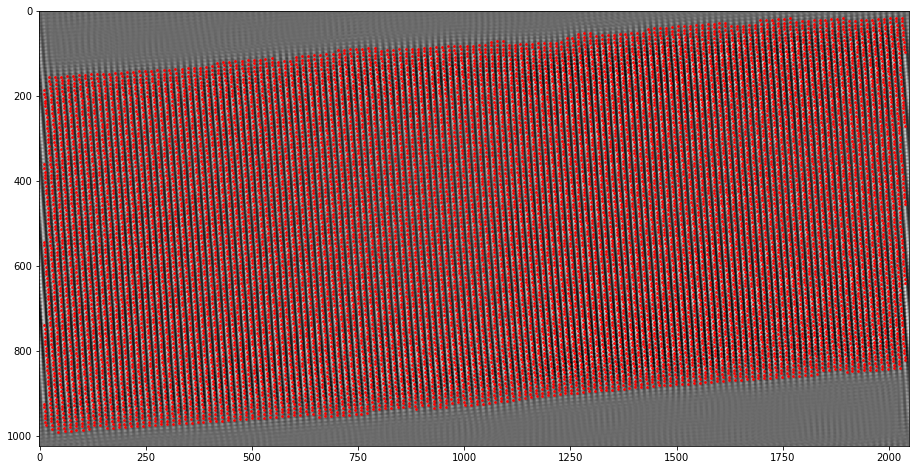

In [12]:
fig, ax = plt.subplots(figsize=(2*figsize, figsize))
ax.imshow(filtered.T)
ax.scatter(points[:,0], points[:,1], s=3, c='r');

## Peak refinement
There are two unambiguous ways of measuring the position of an atomic column: From the position of the intensity extrema or from the center of mass, both methods are implemented through the functions `stm.refine_peaks` and `stm.refine_com`, respectively.

Determining the intensity extrema with sub-pixel accuracy is done by fitting a model function, to a region around the detected extrema. This package includes three choices of models: polynomial, circular Gaussian and elliptical Gaussian, given by respectively:

$$ z(x,y) = z_0 + x + y + x^2 + xy + y^2 \quad , $$

$$ z(x,y) = z_0 + A \exp \left[-\left(\frac{(x - x_0)^2 + (y - y_0)^2}{2\sigma^2}\right)\right] \quad \mathrm{and} $$

$$ z(x,y) = z_0 + A \exp\left[- \left(a(x - x_0)^2 + 2b(x-x_0)(y-y_0) + c(y-y_0)^2 \right)\right] $$
where
$$ a = \frac{\cos^2\theta}{2\sigma_x^2} + \frac{\sin^2\theta}{2\sigma_y^2} \quad , \quad b=-\frac{\sin 2\theta}{4\sigma_x^2} + \frac{\sin 2\theta}{4\sigma_y^2} \quad \mathrm{and} \quad c = \frac{\sin^2\theta }{2\sigma_x^2} + \frac{\cos^2\theta}{2\sigma_y^2}. $$

In [13]:
from stm.feature.peaks import refine_peaks
from skimage.morphology import disk

In [14]:
region = disk(2)
refined = refine_peaks(normalize(filtered), points, region, model='polynomial', progress_bar=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14422/14422 [00:02<00:00, 6481.34it/s]


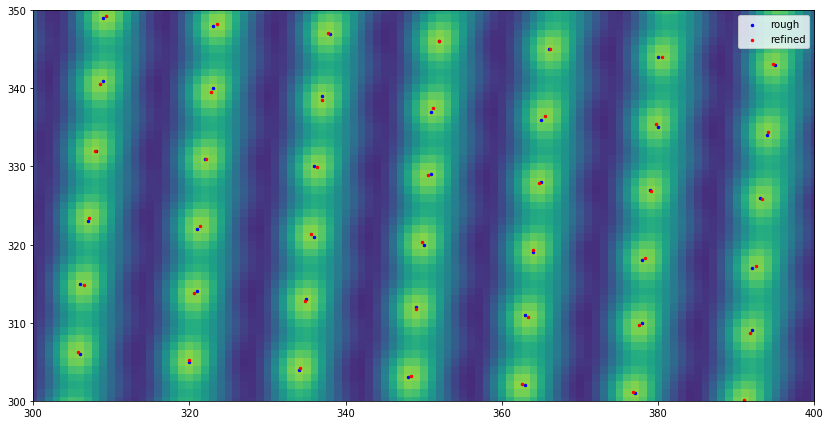

In [15]:
fig, ax = plt.subplots(figsize=(14,8))
ax.scatter(points[:,0], points[:,1], c='b', s=6, label='rough')
ax.scatter(refined[:,0], refined[:,1], c='r', s=6, label='refined')
ax.imshow(filtered.T, cmap='viridis')
ax.set_xlim([300,400])
ax.set_ylim([300,350])

ax.legend();

## Strain analysis overview
Given a set of points, representing the measured positions of structures, the process of calculating strain proceeds through four steps (schematically shown in the figure below).

1. __Segmentation:__ Extract localized pieces of measured points using simple rules. The different methods are described in more detail in the segmentation tutorial.

2. __Template definition:__ Define the expected (or ideal) local lattice piece(s) corresponding to the point segments. 

3. __Template matching:__ For each segment, find the optimal correspondence between each template. This returns the "[Root-Mean-Squared Deviation](https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions)"(RMSD) for each pairing, which is a measure of similarity between the two sets of points.

4. __Strain calculation:__ For each segment, the affine transformation from the best matching template is calculated to the segment is calculated. A polar decomposition is used to obtain rotation, __U__, and the deformation gradient __P__.

The analysis is based on the manipulation of the `Segments` object, which store the indices of the points in each segment of the associated points (2d array). The templates are given as a list of 2d arrays, each array defining a template. After the analysis is finalized the `Segments` object also store several per-segment properties, including reference to the best matching template and the corresponding RMSD, strain etc.

<img src="illustration.png">

## Segmentation
Given the measured points, a set of local point segments are extracted. The segmentation can be done in several different ways, depending on the type of lattice and the desired spatial averaging. The segments can overlap.

A simple method of creating segments is to start from each measured point, and including the $N$ nearest neighbours in each segment. To ensure uniformly sized segments, $N$, should be chosen to fill a neighbour shell, e.g. for a square lattice $N=4,8,12,\ldots$ and for a hexagonal lattice $N=3,9,12,\ldots$.

The present example is a rectangular lattice, and we have chosen to create segments using the 8 nearest neighbours. However, the aspect ratio of the lattice is $\sim 1.6$, this means that the separation between 8'th and 9'th nearest neighbour is small. Consequently, the segmentation is very unstable to small perturbations of the positions. We will instead use a more robust technique that identifies the "holes" around each point and includes points defining the hole. The identification of the holes are given in our paper.

<img src="segmentation.png">

In [17]:
from stm.segment import segment_surrounding_holes

In [24]:
segments = segment_surrounding_holes(refined, k=0.4)

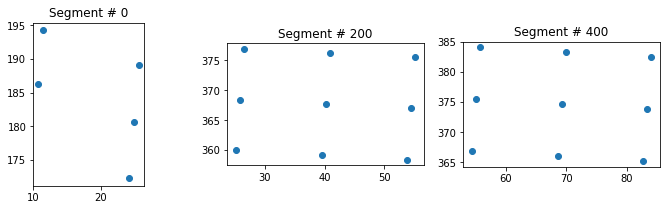

In [25]:
fig,axes=plt.subplots(1,3,figsize=(12,3))

for i,ax in zip([0,200,400],axes):
    ax.scatter(segments[i].points[:,0], segments[i].points[:,1])
    ax.set_title('Segment # {0}'.format(i))
    ax.set_aspect('equal')

## Template definition
The ideal reference lattice(s) have to be defined. This pavkage supports two different approaches for defining the template:
1. Manual definition given knowledge of the expected lattice vectors and basis.
2. Using [cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis) and machine learning to extract templates from averaged groups of segments (see tutorial).

Since the matching algorithm is scale- and rotation invariant, the template can be defined without worrying about pixel size or lattice direction. 

### Point set registration

We use [point set registration](https://en.wikipedia.org/wiki/Point_set_registration) to match each segment with a template (and to calculate the strain). This requires that we find the correspondence between the points in a segment and the points in the templates, or equivalently that they are optimally ordered.

This is exemplified in the figure below. Two templates are shown, _A_ and _B_, the positions of the points are identical. While both are ordered according to the angle around the center, the choice starting points are different. Consequently, the quality of the match to the particular permutation of the points in the segment is very different. 

For our structure, we have 8 points in each segment/template, and the [rotational symmetry order](https://en.wikipedia.org/wiki/Rotational_symmetry) is 2. Hence, there are $8/2=4$ non-equivalent starting points for angular sorting around the center. Generally, the user do not need to worry about this aspect of the analysis. This package automatically recognizes the rotational symmetry order in template positions, and generates the orderings of the templates.

Note that there are $N!$ possible orderings of a set of $N$ points, hence it is necessary to use a robust metric to limit the possible permutations, e.g. ordering by angle as here. For more disordered samples, the assumption that both the templates and each segment can be ordered may not hold. Hence, we also provide a method for finding the optimal ordering using branch and bound search (see example).

<img src="matching.png">

In [27]:
from stm.register import create_template

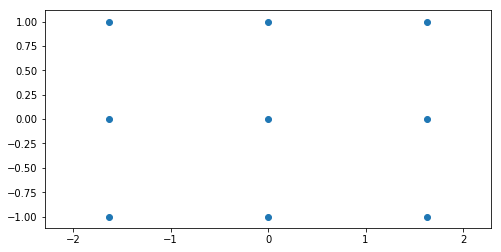

In [29]:
a=np.array([1.,0])*6.996/4.284
b=np.array([0,1.])

template = create_template(a, b, n_points=9)

fig,ax=plt.subplots(1,1,figsize=(figsize,figsize/2))
ax.scatter(template[:,0],template[:,1])
ax.axis('equal');

## Point registration
To each segment, the 4 templates are compared using the RMSD and the template with lowest RMSD is attached segment.

Denoting the set of $N$ points in a segment $P=\{p_i\}$ and a given template, $Q=\{q_i\}$, with the same number of points. The RMSD is calculated as

$$ RMSD(P,Q) = \sqrt{\frac{1}{N} \sum_{i=1}^N \|(p_i - p_0) - (q_i - q_0)\|_2^2} \quad ,$$

where $p_0$ and $q_0$ is the segment and template origin, respectively. The RMSD is made invariant to scale (absolute and relative) and rotation, by finding the optimal rotation and scale, between the two sets of points.

$$ RMSD(P,Q) = \min_{U,s} \sqrt{\frac{1}{N} \sum_{i=1}^N \|s(p_i - p_0) - \frac{1}{S(T)}U(q_i - q_0)\|_2^2} \quad , $$

where $s$ is a number (the scale factor), $U$ is an orthogonal matrix (the rotation matrix) and 
$$
S(Q) = \sqrt{\frac{1}{N} \sum_{i=1}^N q_i^2}.
$$

## Strain calculation
The orientation and deformation gradient matrices are obtained via a left-sided polar decomposition of the deformation gradient
$$ PU = A \quad , $$
where U is an orthogonal right-handed matrix (the rotation matrix), and P is a symmetric matrix (the deformation gradient). The components of the strain tensor is are then calculated as
$$ \begin{bmatrix}
\epsilon_{xx} & \epsilon_{xy} \\
\epsilon_{yx} & \epsilon_{yy} \\
\end{bmatrix} = 
\begin{bmatrix}
P_{1,1} - 1 & P_{1,2} \\
P_{2,1} & P_{2,2} -1 \\
\end{bmatrix} \quad ,$$ 
and the rotation is given by 
$$ \theta = (\operatorname{atan2}(U_{1,0},U_{0,0}) + \pi) \ \mathrm{mod} \ \pi \quad . $$
Note that since the rotation is only defined modulo $2\pi/n$ where $n$ is rotational symmetry order of the template.

We did not define the scale of the template, hence it is necessary to recalibrate the strain tensor. This is done by requiring that the mean planar strain over a region is zero
\begin
$$\bar{\epsilon_p} = \frac{1}{M} \sum_i (\epsilon_{xx}^{(i)}+\epsilon_{yy}^{(i)})/2 = 0$$
where the sum is over all segments in a given region, $M$ is the number of segments and $\epsilon_{xx}^(i),\epsilon_{yy}^(i)$ are the strain components of the $i$'th segment. Thus the rescaled strains are given by
$$ \epsilon_{xx} = (\epsilon_{xx} - 1)/ \bar{\epsilon_p} + 1 \quad \mathrm{and} \quad \epsilon_{yy} = (\epsilon_{yy} - 1)/ \bar{\epsilon_p} + 1 \quad .$$ 
Below we rescale using the trimmed mean of strain in all segments. The trimmed mean is used to avoid erroneuous outliers skewing the mean.

In [33]:
segments.match(template)

segments.calibrate_strain(.2)

segments.calibrate_direction(.2, rotate_points=True)

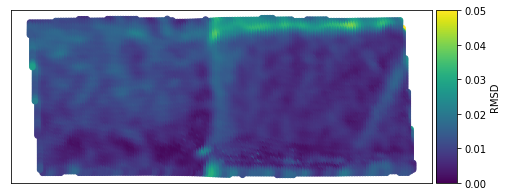

In [34]:
fig,ax=plt.subplots(1, 1, figsize=(figsize,figsize/2))

sc = ax.scatter(segments.origins[:,0], segments.origins[:,1], c=segments.rmsd, cmap='viridis', vmin=0, vmax=.05, s=30)
add_colorbar(ax, sc, label='RMSD')

ax.set_aspect('equal', adjustable='box')
ax.set_xticks([])
ax.set_yticks([]);

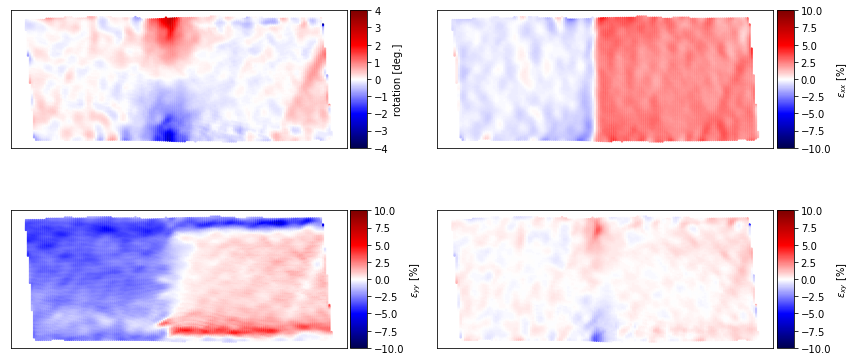

In [35]:
s = 2

fig,axes=plt.subplots(2, 2, figsize=(3*figsize/2,3*figsize/4))

sc = axes[0,0].scatter(segments.origins[:,0], segments.origins[:,1], 
                       c=segments.rotation / np.pi * 180, cmap='seismic', vmin=-4, vmax=4, s=s)
add_colorbar(axes[0,0], sc, label='rotation [deg.]')

sc = axes[0,1].scatter(segments.origins[:,0], segments.origins[:,1], 
                        c=segments.strain[:,0,0]*100, cmap='seismic', vmin=-10, vmax=10, s=s)
add_colorbar(axes[0,1], sc, label = '$\epsilon_{xx}$ [%]')

sc = axes[1,0].scatter(segments.origins[:,0], segments.origins[:,1], 
                        c=segments.strain[:,1,1]*100, cmap='seismic', vmin=-10, vmax=10, s=s)
add_colorbar(axes[1,0], sc, label = '$\epsilon_{yy}$ [%]')

sc = axes[1,1].scatter(segments.origins[:,0], segments.origins[:,1], 
                        c=segments.strain[:,0,1]*100, cmap='seismic', vmin=-10, vmax=10, s=s)
add_colorbar(axes[1,1], sc, label='$\epsilon_{xy}$ [%]')

for ax in axes.ravel():
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()

## Interpolation and strain profiles
For some purposes, such as getting the strain profile along a line, it is practical to represent the strain on spatially resolved grid. The `griddata` function from Scipy can be used to interpolate the strain from the irregular segment positions to a regular grid.

In [37]:
from scipy.interpolate import griddata
from stm.utils import running_mean

In [38]:
x,y=np.indices(image.shape)

exx = griddata(segments.origins, segments.strain[:,0,0], (x,y), method='linear')
eyy = griddata(segments.origins, segments.strain[:,1,1], (x,y), method='linear')

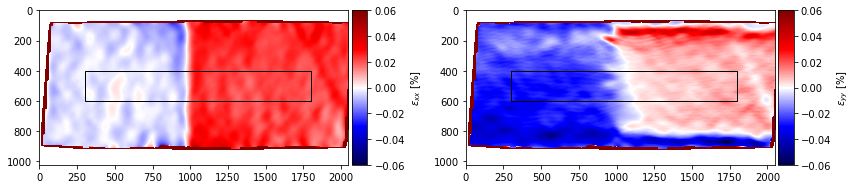

In [39]:
xlim=[300,1800]
ylim=[400,600]

fig,axes=plt.subplots(1,2,figsize=(3*figsize/2,3*figsize/4))

im = axes[0].imshow(exx.T, cmap = 'seismic', interpolation='nearest', vmin=-.06, vmax=.06)
add_colorbar(axes[0], im, label = '$\epsilon_{xx}$ [%]')

im = axes[1].imshow(eyy.T, cmap = 'seismic', interpolation='nearest', vmin=-.06, vmax=.06)
add_colorbar(axes[1], im, label = '$\epsilon_{yy}$ [%]')

for ax in axes:
    ax.add_patch(matplotlib.patches.Rectangle((xlim[0], ylim[0]),
                    xlim[1]-xlim[0], ylim[1]-ylim[0], fill=False))
    
plt.tight_layout()

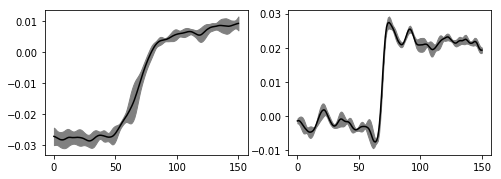

In [40]:
N=10

eyy_rectangle = eyy[xlim[0]:xlim[1],ylim[0]:ylim[1]]
exx_rectangle = exx[xlim[0]:xlim[1],ylim[0]:ylim[1]]

eyy_mean = running_mean(np.mean(eyy_rectangle, axis=1), N)
exx_mean = running_mean(np.mean(exx_rectangle, axis=1), N)

eyy_err = running_mean(np.std(eyy_rectangle, axis=1), N)
exx_err = running_mean(np.std(exx_rectangle, axis=1), N)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(figsize,figsize/3))

x = np.linspace(0, len(eyy_mean), len(eyy_mean))

ax1.plot(x, eyy_mean, 'k')
ax1.fill_between(x, eyy_mean - eyy_err, eyy_mean + eyy_err, color='gray')

ax2.plot(x, exx_mean, 'k')
ax2.fill_between(x, exx_mean - exx_err, exx_mean + exx_err, color='gray');